### Feature extraction part

In [27]:
import librosa
import numpy as np
from skimage.feature import local_binary_pattern, hog
from src.music_recommender.config import Config
from pathlib import Path
from typing import Tuple
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
import pandas as pd
import librosa.display
import matplotlib.pyplot as plt
import joblib

In [14]:
cfg = Config()
asp = cfg.paths.processed / "audio"

In [34]:
def resample(aud_sr: Tuple[np.ndarray, float], new_sr: int) -> Tuple[np.ndarray, float]:
    aud, sr = aud_sr
    if sr == new_sr:
        return aud, sr
    if aud.ndim == 1:
        res_aud = librosa.resample(aud, orig_sr=sr, target_sr=new_sr)
    else:
        res_aud = np.stack(
            [librosa.resample(channel, orig_sr=sr, target_sr=new_sr) for channel in aud]
        )
    return res_aud, new_sr


def rechannel(
    aud_sr: Tuple[np.ndarray, float], new_ch: int
) -> Tuple[np.ndarray, float]:
    aud, sr = aud_sr
    n_ch = 1 if aud.ndim == 1 else aud.shape[0]
    if n_ch == new_ch:
        return aud_sr
    if new_ch == 1:
        res_aud = np.mean(aud, axis=0, keepdims=True)
    if new_ch == 2:
        res_aud = np.stack([aud, aud])
    else:
        raise ValueError(f"Unsupported number of channels: {new_ch}")
    return res_aud, sr


def load_spectr(
    audio_path: Path,
    n_fft: int = 2048,
    hop_length: int = 512,
    n_mels=40,
) -> Tuple[np.ndarray, float]:
    try:
        aud_sr = librosa.load(audio_path)
        aud_sr = rechannel(aud_sr=aud_sr, new_ch=1)
        aud_sr = resample(aud_sr=aud_sr, new_sr=16000)
        aud, sr = aud_sr
        spect = librosa.feature.melspectrogram(
            y=aud, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels
        )
        spect_db = librosa.power_to_db(spect, ref=np.max)
        return spect_db, sr
    except Exception as e:
        raise ValueError(f"no audio here {audio_path} ,error: {e} man")


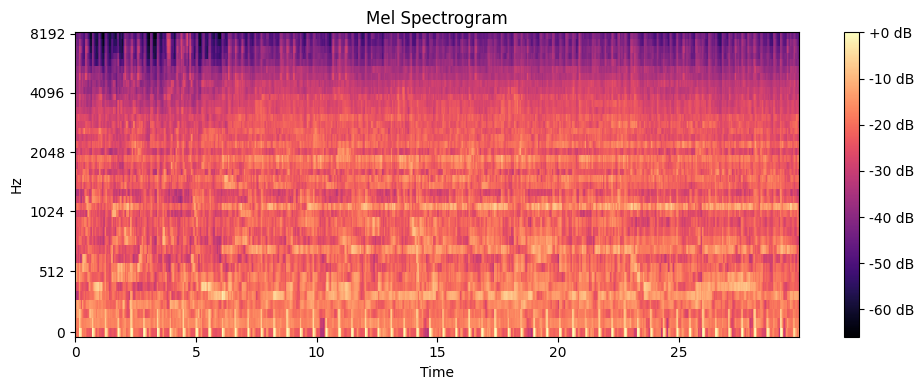

In [35]:
spect_sr = load_spectr(asp / "000010.mp3")
spect, sr = spect_sr
spect_db = librosa.power_to_db(spect, ref=np.max)

plt.figure(figsize=(10, 4))
librosa.display.specshow(spect, sr=sr, x_axis="time", y_axis="mel")
plt.colorbar(format="%+2.0f dB")
plt.title("Mel Spectrogram")
plt.tight_layout()
plt.show()


In [17]:
np.histogram(local_binary_pattern(spect, 8, 1, method="uniform").ravel(), bins=256)


/home/moad/desktop/music-recommender/.venv/lib/python3.11/site-packages/skimage/feature/texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


(array([2471,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0, 4026,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0, 2244,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0, 4471,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0, 5956,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0, 4791,
           0,    0,    0,    0,    0, 

In [18]:
def reduce_lbp_patterns(subband_hist: np.ndarray) -> np.ndarray:
    representative_patterns = [
        0b00000000,  # Flat (face)
        0b11111111,  # Flat (face)
        0b00001111,  # Edge
        0b11110000,  # Edge
        0b00111100,  # Edge
        0b11000011,  # Edge
        0b00000011,  # Corner
        0b00000110,  # Corner
        0b00001100,  # Corner
        0b00011000,  # Corner
        0b00110000,  # Corner
        0b01100000,  # Corner
        0b11000000,  # Corner
        0b10000001,  # Corner
        0b01111110,  # Edge variation
        0b00111111,  # Edge variation
        0b11111100,  # Edge variation
        0b11111000,  # Edge variation
    ]
    lbp_18 = np.zeros(18)
    for code in range(256):
        if subband_hist[code] > 0:
            min_dist = 8
            best_idx = 17

            for idx, pattern in enumerate(representative_patterns):
                dist = bin(code ^ pattern).count("1")
                if dist < min_dist:
                    min_dist = dist
                    best_idx = idx

            lbp_18[best_idx] += subband_hist[code]
    return lbp_18

In [ ]:
def extract_lbp(
    spect: np.ndarray, nbr_subband: int = 6, nbr_point: int = 8, radius: int = 1
) -> np.ndarray:
    subband_height = spect.shape[0] // nbr_subband
    lbp_features = []

    for i in range(nbr_subband):
        start = i * subband_height
        end = (i + 1) * subband_height if i < nbr_subband - 1 else spect.shape[0]
        subband = spect[start:end, :]

        lbp_feature, _ = np.histogram(
            local_binary_pattern(subband, nbr_point, radius, method="uniform"),
            bins=256,
            range=(0, 256),
        )
        lbp_feature_reduced = reduce_lbp_patterns(lbp_feature)
        lbp_features.append(lbp_feature_reduced)
    return np.concatenate(lbp_features)

In [ ]:
def extract_hog(spect: np.ndarray, nbr_subband=6, orientations=9) -> np.ndarray:
    subband_height = spect.shape[0] // nbr_subband
    hog_features = []

    for i in range(nbr_subband):
        start = i * subband_height
        end = (i + 1) * subband_height if i < nbr_subband - 1 else spect.shape[0]
        subband = spect[start:end, :]

        fd = hog(
            subband,
            orientations=orientations,
            pixels_per_cell=(subband.shape[0], subband.shape[1]),
            cells_per_block=(1, 1),
            visualize=False,
            feature_vector=True,
        )

        fd = fd / (np.linalg.norm(fd) + 1e-8)
        hog_features.append(fd)

    return np.concatenate(hog_features)


In [ ]:
def extract_lbp_hog_segments(
    spect: np.ndarray, segment_frames: int = 10, hop_frames: int = 1
) -> np.ndarray:
    features = []
    n_frames = spect.shape[1]
    for start in range(0, n_frames - segment_frames + 1, hop_frames):
        segment = spect[:, start : start + segment_frames]
        segment = segment.T
        lbp_features = extract_lbp(segment)
        hog_segment = extract_hog(segment)

        lbp_hog_features = np.concatenate([lbp_features, hog_segment])
        features.append(lbp_hog_features)

    return np.array(features)


In [ ]:
from sklearn.mixture import GaussianMixture


def train_boaw_codebook(
    all_features: np.ndarray, n_words: int = 512
) -> GaussianMixture:
    gmm = GaussianMixture(n_components=n_words, covariance_type="diag", random_state=42)
    gmm.fit(all_features)
    return gmm

In [ ]:
def extract_boaw_histogram(features: np.ndarray, gmm: GaussianMixture):
    assignments = gmm.predict(features)

    hist = np.bincount(assignments, minlength=gmm.n_components)

    hist = hist.astype(float) / (hist.sum() + 1e-8)

    return hist

In [ ]:
feat = extract_lbp_hog_segments(spect=spect)
gmm = train_boaw_codebook(feat)
hist = extract_boaw_histogram(features=feat, gmm=gmm)
hist.shape

(512,)

### ML part

In [36]:
from numpy import ndarray


class SpectrogramExtractor(BaseEstimator, TransformerMixin):
    def __init__(
        self,
        new_sr: int = 16000,
        new_ch: int = 1,
        n_fft: int = 2048,
        hop_length: int = 512,
        n_mels=40,
    ) -> None:
        super().__init__()
        self.new_ch = new_ch
        self.new_sr = new_sr
        self.n_fft = n_fft
        self.hop_length = hop_length
        self.n_mels = n_mels

    @staticmethod
    def _resample(
        aud_sr: Tuple[np.ndarray, float], new_sr: int
    ) -> Tuple[np.ndarray, float]:
        aud, sr = aud_sr
        if sr == new_sr:
            return aud, sr
        if aud.ndim == 1:
            res_aud = librosa.resample(aud, orig_sr=sr, target_sr=new_sr)
        else:
            res_aud = np.stack(
                [
                    librosa.resample(channel, orig_sr=sr, target_sr=new_sr)
                    for channel in aud
                ]
            )
        return res_aud, new_sr

    @staticmethod
    def _rechannel(
        aud_sr: Tuple[np.ndarray, float], new_ch: int
    ) -> Tuple[np.ndarray, float]:
        aud, sr = aud_sr
        n_ch = 1 if aud.ndim == 1 else aud.shape[0]
        if n_ch == new_ch:
            return aud_sr
        if new_ch == 1:
            res_aud = np.mean(aud, axis=0, keepdims=True)
        if new_ch == 2:
            res_aud = np.stack([aud, aud])
        else:
            raise ValueError(f"Unsupported number of channels: {new_ch}")
        return res_aud, sr

    @staticmethod
    def _load_spectr(
        audio_path: Path,
        n_fft: int = 2048,
        hop_length: int = 512,
        n_mels=40,
    ) -> Tuple[np.ndarray, float]:
        try:
            aud_sr = librosa.load(audio_path)
            aud_sr = rechannel(aud_sr=aud_sr, new_ch=1)
            aud_sr = resample(aud_sr=aud_sr, new_sr=16000)
            aud, sr = aud_sr
            spect = librosa.feature.melspectrogram(
                y=aud, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels
            )
            spect_db = librosa.power_to_db(spect, ref=np.max)
            return spect_db, sr
        except Exception as e:
            raise ValueError(f"no audio here {audio_path} ,error: {e} man")

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        np.array(
            [
                self._load_spectr(
                    path,
                    n_fft=self.n_fft,
                    hop_length=self.hop_length,
                    n_mels=self.n_mels,
                )[0]
                for path in X
            ]
        )

In [ ]:
class LBPHOGSegmentExtractor(BaseEstimator, TransformerMixin):
    def __init__(
        self,
        nbr_subband: int = 6,
        nbr_point: int = 8,
        radius: int = 1,
        orientations=9,
        segment_frames: int = 10,
        hop_frames: int = 1,
    ) -> None:
        super().__init__()
        self.nbr_subband = nbr_subband
        self.nbr_point = nbr_point
        self.radius = radius
        self.orientations = orientations
        self.segment_frames = segment_frames
        self.hop_frames = hop_frames

    @staticmethod
    def _extract_lbp(
        spect: np.ndarray, nbr_subband: int = 6, nbr_point: int = 8, radius: int = 1
    ) -> np.ndarray:
        subband_height = spect.shape[0] // nbr_subband
        lbp_features = []

        for i in range(nbr_subband):
            start = i * subband_height
            end = (i + 1) * subband_height if i < nbr_subband - 1 else spect.shape[0]
            subband = spect[start:end, :]

            lbp_feature, _ = np.histogram(
                local_binary_pattern(subband, nbr_point, radius, method="uniform"),
                bins=256,
                range=(0, 256),
            )
            lbp_feature_reduced = reduce_lbp_patterns(lbp_feature)
            lbp_features.append(lbp_feature_reduced)
        return np.concatenate(lbp_features)

    @staticmethod
    def _extract_hog(spect: np.ndarray, nbr_subband=6, orientations=9) -> np.ndarray:
        subband_height = spect.shape[0] // nbr_subband
        hog_features = []

        for i in range(nbr_subband):
            start = i * subband_height
            end = (i + 1) * subband_height if i < nbr_subband - 1 else spect.shape[0]
            subband = spect[start:end, :]

            fd = hog(
                subband,
                orientations=orientations,
                pixels_per_cell=(subband.shape[0], subband.shape[1]),
                cells_per_block=(1, 1),
                visualize=False,
                feature_vector=True,
            )

            fd = fd / (np.linalg.norm(fd) + 1e-8)
            hog_features.append(fd)

        return np.concatenate(hog_features)

    def _extract_lbp_hog_segments(
        self, spect: np.ndarray, segment_frames: int = 10, hop_frames: int = 1
    ) -> np.ndarray:
        features = []
        n_frames = spect.shape[1]
        for start in range(0, n_frames - segment_frames + 1, hop_frames):
            segment = spect[:, start : start + segment_frames]
            segment = segment.T
            lbp_features = self._extract_lbp(
                spect=segment,
                nbr_subband=self.nbr_subband,
                nbr_point=self.nbr_point,
                radius=self.radius,
            )
            hog_segment = self._extract_hog(
                spect=segment,
                nbr_subband=self.nbr_subband,
                orientations=self.orientations,
            )

            lbp_hog_features = np.concatenate([lbp_features, hog_segment])
            features.append(lbp_hog_features)

        return np.array(features)

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return np.array(
            [
                self._extract_lbp_hog_segments(
                    spect=spect,
                    segment_frames=self.segment_frames,
                    hop_frames=self.hop_frames,
                )
                for spect in X
            ]
        )

class BOAWEncoder(BaseEstimator, TransformerMixin):
    def __init__(self,n_words: int = 512) -> None:
        super().__init__()
        self.n_words = n_words
    
    @staticmethod
    def _train_boaw_codebook(
    all_features: np.ndarray, n_words: int = 512
) -> GaussianMixture:
        gmm = GaussianMixture(n_components=n_words, covariance_type="diag", random_state=42)
        gmm.fit(all_features)
        return gmm
    
    @staticmethod
    def _extract_boaw_histogram(features: np.ndarray, gmm: GaussianMixture):
        assignments = gmm.predict(features)

        hist = np.bincount(assignments, minlength=gmm.n_components)

        hist = hist.astype(float) / (hist.sum() + 1e-8)

        return hist
    def fit(self, X, y = None):
        all_feature = np.vstack(X)
        self.gmm = self._train_boaw_codebook(all_features=all_feature,n_words=self.n_words)
        return self
    def transform(self, X):
       return np.array([extract_boaw_histogram(features, self.gmm) 
                        for features in X])
    